In [23]:
import boto3 
from boto3.session import Session 
import pandas as pd 
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from collections import Counter

import pandas as pd
import numpy as np
import re  
import matplotlib.pyplot as plt 
import seaborn as sns 

In [5]:
import configparser
Config = configparser.ConfigParser()
Config.read_file(open('/Users/milesklingenberg/Documents/Personal/AWS_Keys'))

In [6]:
KEY = Config.get('AWS', 'AWS_ACCESS_KEY_ID')
SECRET = Config.get('AWS', 'Secret')

In [7]:
#we are storing the data on AWS. 

s3 = boto3.resource('s3',
                       region_name="us-west-2",
                       aws_access_key_id=KEY,
                       aws_secret_access_key=SECRET
                   )
s3client = boto3.client('s3', 
                       aws_access_key_id=KEY,
                       aws_secret_access_key=SECRET)

In [8]:
#Just a list to look at my available buckets for naming conventions. 
#for bucket in s3.buckets.all():
    #print(bucket.name)

In [9]:
file = s3client.get_object(Bucket = 'lyrics-for-570', Key = 'lyrics.csv')

#If you want to read this yourself just replace the pr.read_csv to the local path for your data, otherwise 
#this s3 bucket is public. 

In [10]:
lyrics = pd.read_csv(file['Body'])
lyrics = pd.DataFrame(lyrics)

In [11]:
#Want to look at the structure of our data set. 
print(lyrics.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362237 entries, 0 to 362236
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   index   362237 non-null  int64 
 1   song    362235 non-null  object
 2   year    362237 non-null  int64 
 3   artist  362237 non-null  object
 4   genre   362237 non-null  object
 5   lyrics  266557 non-null  object
dtypes: int64(2), object(4)
memory usage: 16.6+ MB
None


In [12]:
#We will probably need to run this on a virtual server in order to do ETL and 
#modeling for 

#When we are ready to deploy this model we will want to remove this portion and 
#extend efforts to whole data set. 

lyrics = lyrics[0:10000]

In [13]:
#switching variables here as it takes awhile to load in the data each time. 
lyrics_1 = lyrics
#We can also take a peak at the data 
print(lyrics.head(10))

   index                    song  year           artist genre  \
0      0               ego-remix  2009  beyonce-knowles   Pop   
1      1            then-tell-me  2009  beyonce-knowles   Pop   
2      2                 honesty  2009  beyonce-knowles   Pop   
3      3         you-are-my-rock  2009  beyonce-knowles   Pop   
4      4           black-culture  2009  beyonce-knowles   Pop   
5      5  all-i-could-do-was-cry  2009  beyonce-knowles   Pop   
6      6      once-in-a-lifetime  2009  beyonce-knowles   Pop   
7      7                 waiting  2009  beyonce-knowles   Pop   
8      8               slow-love  2009  beyonce-knowles   Pop   
9      9   why-don-t-you-love-me  2009  beyonce-knowles   Pop   

                                              lyrics  
0  Oh baby, how you doing?\nYou know I'm gonna cu...  
1  playin' everything so easy,\nit's like you see...  
2  If you search\nFor tenderness\nIt isn't hard t...  
3  Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...  
4  Party 

In [14]:
#typically we could sub values where there are Null, but for lyrics this is obviously not possible, so we 
#will remove 

In [15]:
#We know that the length of our data is 30k 
lyrics_1 = lyrics_1.dropna()

#You could label based on the artist and the propensity for offensiveness. 
#Something that was annoying is that the csv actually had "nan" as an entry as opposed 
#to actually nan value. 

In [ ]:
#This function does all of the preprocessing steps for us. 

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)


lyrics_1['lyrics_cleaned_total']=lyrics_1['lyrics'].map(lambda s:preprocess(s)) 

##lambda exampe.  lyrics['test']= lyrics['lyrics'].apply(lambda x: 1 if len(x) > 1)

In [17]:
#lyrics_1.drop(lyrics_1.columns[len(lyrics_1.columns)-1], axis=1, inplace=True)

In [169]:
lyrics_1

index                       song  year           artist          genre  \
0         0                  ego-remix  2009  beyonce-knowles            Pop   
1         1               then-tell-me  2009  beyonce-knowles            Pop   
2         2                    honesty  2009  beyonce-knowles            Pop   
3         3            you-are-my-rock  2009  beyonce-knowles            Pop   
4         4              black-culture  2009  beyonce-knowles            Pop   
...     ...                        ...   ...              ...            ...   
9959   9959            the-fishin-hole  1993    andy-griffith  Not Available   
9963   9963    the-andy-griffith-theme  1993    andy-griffith  Not Available   
9967   9967       the-midnight-special  1993    andy-griffith  Not Available   
9968   9968  the-preacher-and-the-bear  1993    andy-griffith  Not Available   
9972   9972  make-yourself-comfortable  1993    andy-griffith  Not Available   

                                                 lyrics  \
0     Oh baby, how you doing?\nYou know I'm gonna cu...   
1     playin' everything so easy,\nit's like you see...   
2     If you search\nFor tenderness\nIt isn't hard t...   
3     Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...   
4     Party the people, the people the party it's po...   
...                                                 ...   
9959  Andy Griffith\nMiscellaneous\nFishing Hole\nWe...   
9963  Maybe live for the dark leaves\nShake the floo...   
9967  One day, one day, Sir\nI was walking along\nI ...   
9968  Now the preacher sat up in the tree ,\nSome sa...   
9972  Ooh ooh make yourself comfortable\nOoh ooh mak...   

                                   lyrics_cleaned_total  
0     baby know gonna cut right chase women made lik...  
1     playin everything easy like seem sure still wa...  
2     search tenderness hard find love need live loo...  
3     verse wrote book stand title book would life s...  
4     party people people party popping sitting arou...  
...                                                 ...  
9959  andy griffith miscellaneous fishing hole well ...  
9963  maybe live dark leaves shake floor seeds come ...  
9967  one day one day sir walking along heard specia...  
9968  preacher sat tree sayhe hidded night along day...  
9972  ooh ooh make comfortable ooh ooh make comforta...  

[6988 rows x 7 columns]

In [124]:
l = [' '.join(lyrics_1['lyrics_cleaned_total'])]

In [167]:
def word_count(obj): 
    frequencies = pd.DataFrame()
    obj = str(obj)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(obj)
    counts = Counter(tokens)
    frame = frequencies.append(
         counts.most_common(n=100),
         counts)
    return frame

total_df = word_count(l)
total_df.columns = ['word', 'count']
total_df.sort_values('count', ascending=False)
top_word_count = total_df.head(30)

In [281]:
total_df.head(5)

word  count
0  like   8389
1  know   8229
2  love   7560
3   get   6600
4   got   5883

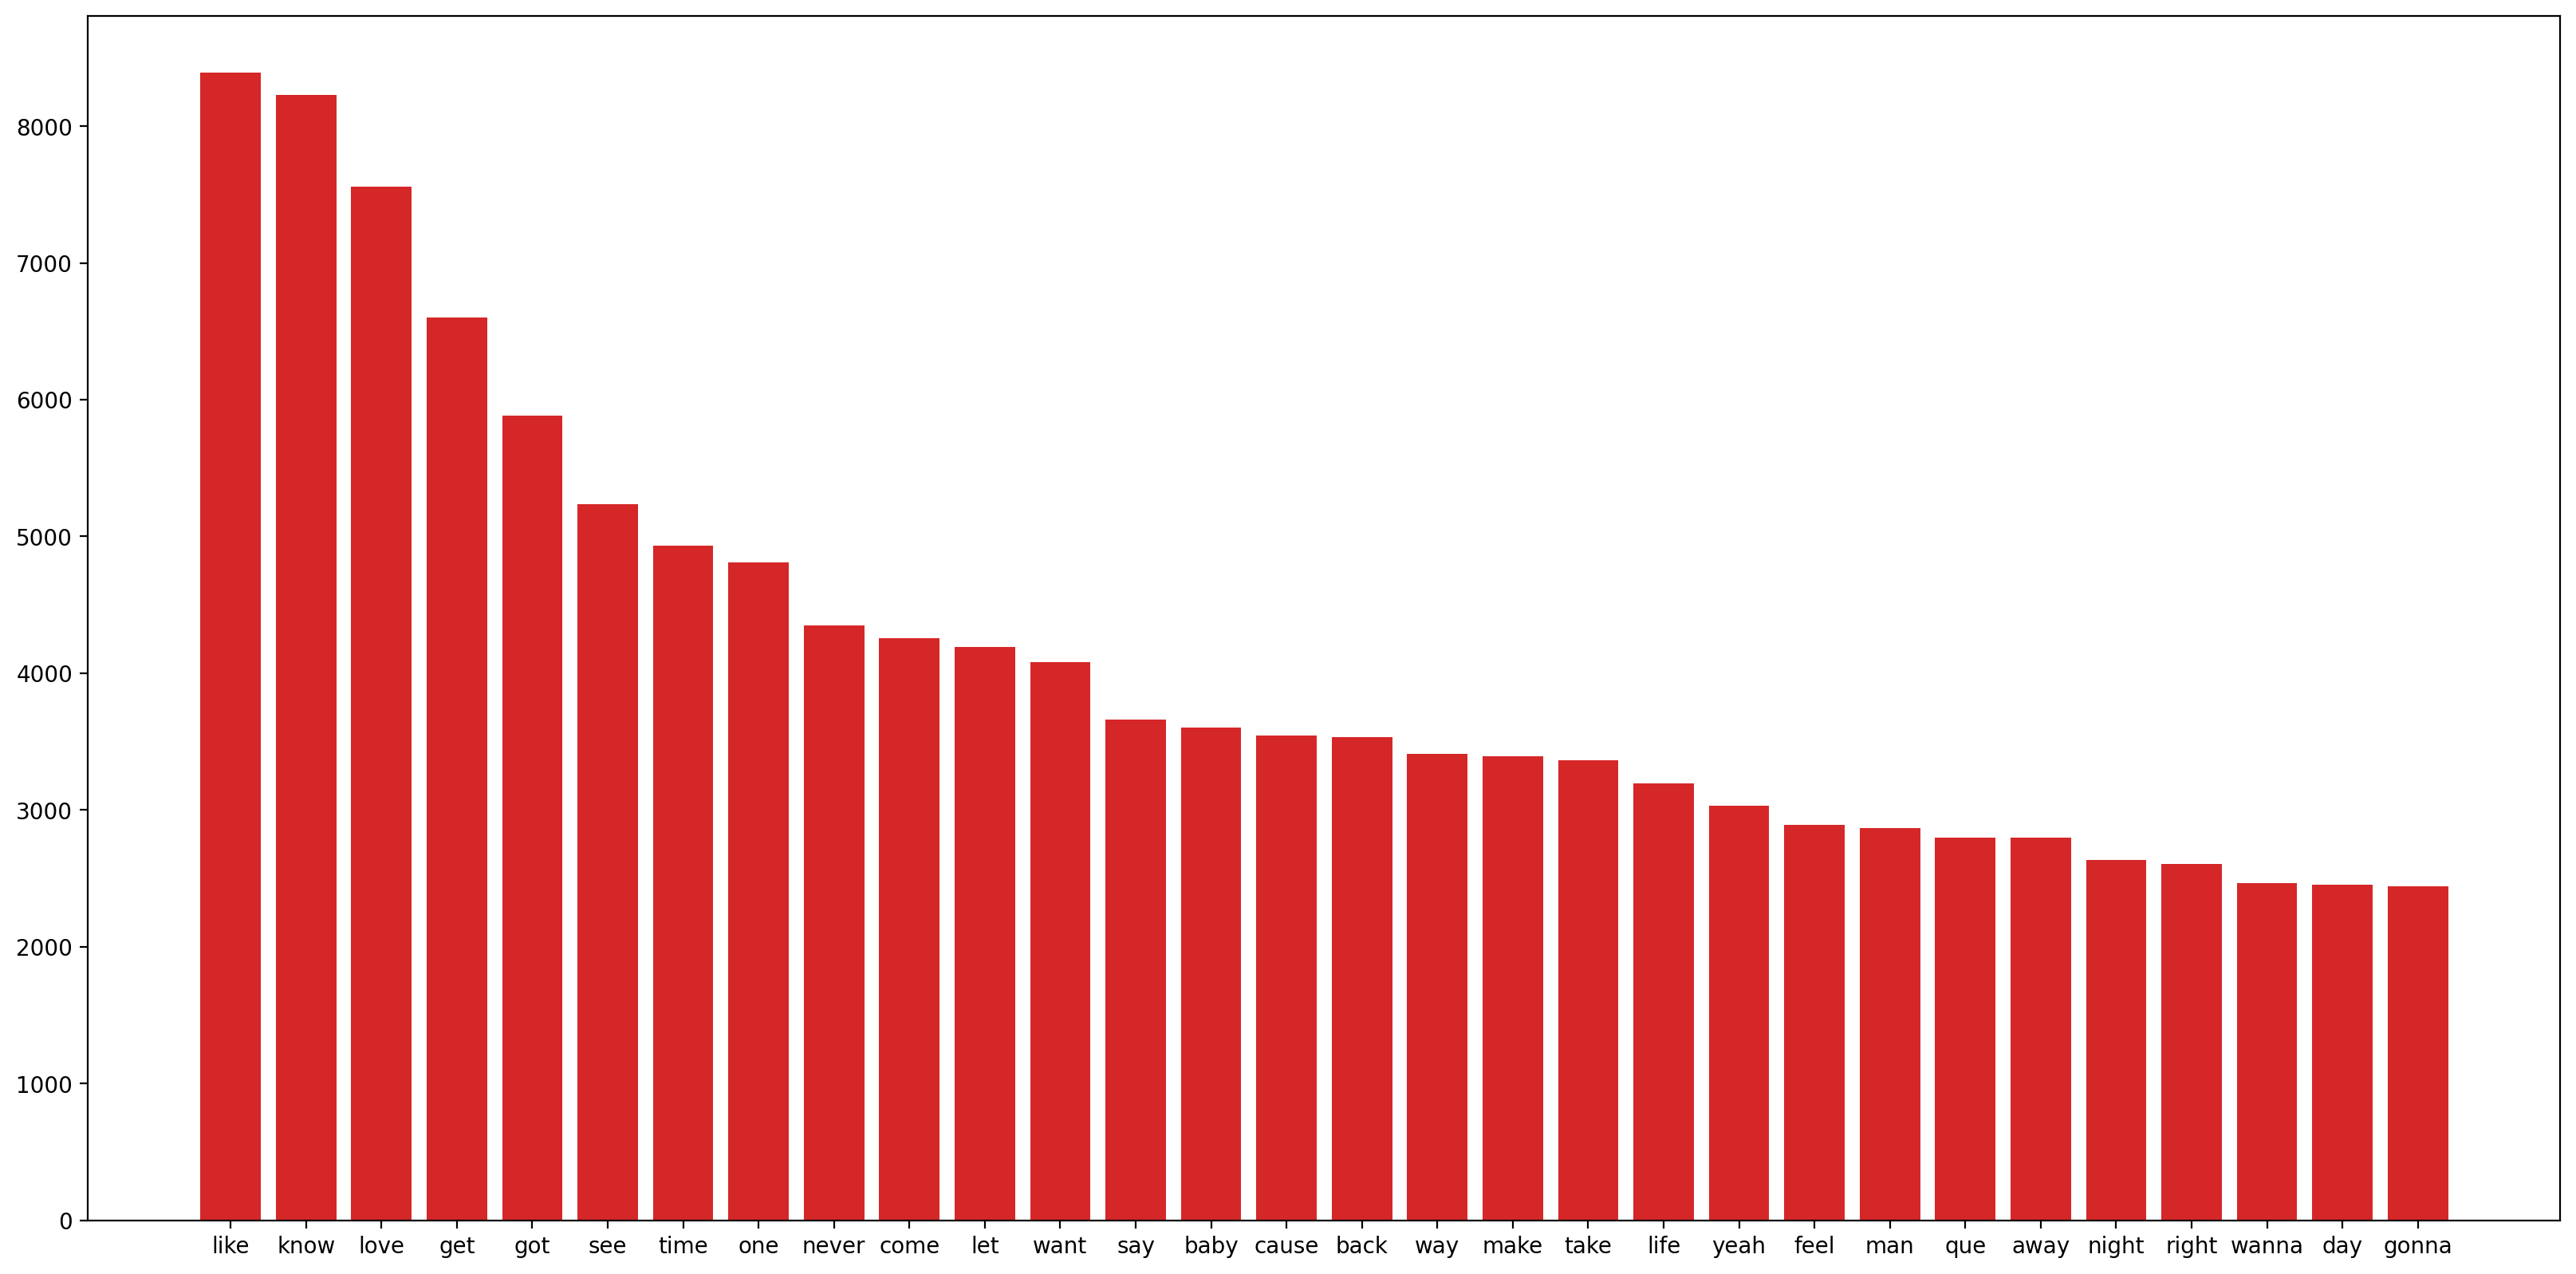

In [168]:
plt.figure(figsize=(20,10), dpi=200)
color = 'tab:red'
plt.bar(top_word_count['word'], top_word_count['count'],color=color)

plt.show()

#This plot shows us the most used words. 

In [ ]:
lyrics_1['word_count_total'] = lyrics_1['lyrics_cleaned_total'].str.count(' ') + 1 

In [ ]:
word_counts = []
unique_word_counts = []
for i in range (0, len(lyrics_1)):
    word_counts.append(len(lyrics_1.iloc[i]['lyrics_cleaned_total'].split()))
    unique_word_counts.append(len(set(lyrics_1.iloc[i]['lyrics_cleaned_total'].split())))
lyrics_1['Word Counts'] = word_counts
lyrics_1['Unique Words'] = unique_word_counts

In [282]:
lyrics_1.head(5)
#Just checking to make sure that the two columns were appended correctly. 

index             song  year           artist genre  \
0      0        ego-remix  2009  beyonce-knowles   Pop   
1      1     then-tell-me  2009  beyonce-knowles   Pop   
2      2          honesty  2009  beyonce-knowles   Pop   
3      3  you-are-my-rock  2009  beyonce-knowles   Pop   
4      4    black-culture  2009  beyonce-knowles   Pop   

                                              lyrics  \
0  Oh baby, how you doing?\nYou know I'm gonna cu...   
1  playin' everything so easy,\nit's like you see...   
2  If you search\nFor tenderness\nIt isn't hard t...   
3  Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...   
4  Party the people, the people the party it's po...   

                                lyrics_cleaned_total  word_count_total  \
0  baby know gonna cut right chase women made lik...               182   
1  playin everything easy like seem sure still wa...               115   
2  search tenderness hard find love need live loo...                73   
3  verse wrote book stand title book would life s...               190   
4  party people people party popping sitting arou...               151   

   Word Counts  Unique Word Counts  
0          182                  85  
1          115                  70  
2           73                  58  
3          190                  73  
4          151                  23

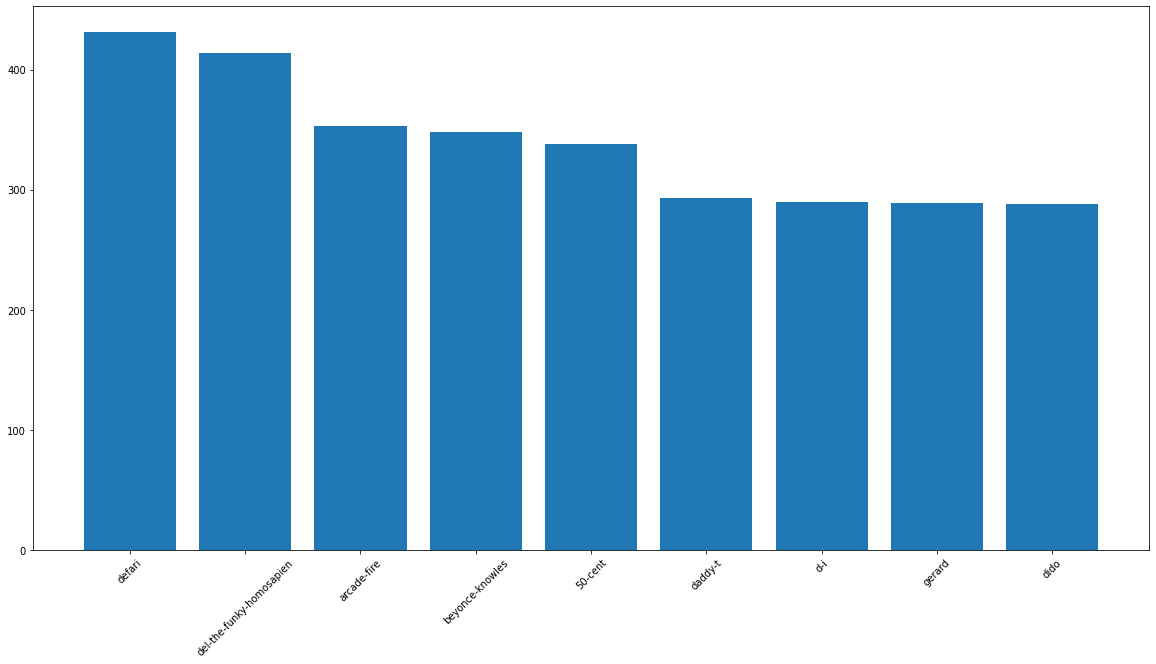

In [266]:
artist_table = lyrics_1.sort_values('Unique Words', ascending = False)
artist_table = artist_table.head(30)
plt.figure(figsize = (20,10))

plt.bar(artist_table['artist'], artist_table['Unique Words'].values)
plt.xticks(rotation = 45)
plt.show()

#Here we can see the total number of unique word used by the artists with the most unique words. 

In [268]:
plt.figure(figsize=(20,10), dpi=200)
plt.plot(lyrics['year'], lyrics['Average Words'].values, color="red", label="Average Words")
plt.show()

KeyError: 'Year'

<Figure size 4000x2000 with 0 Axes>